# Plot EM Slopes

Make some plots to show the EM slope for varying heating frequency

In [2]:
import os

import numpy as np
from scipy.optimize import curve_fit
import scipy.linalg
import scipy.stats
from scipy.interpolate import interp1d,splev,splrep
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
import astropy.constants as const
from sunpy.map import Map,GenericMap

from synthesizAR.util import EMCube

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [96]:
frequencies = [250,
               750,
               #'750-ion',
               2500,
               5000]

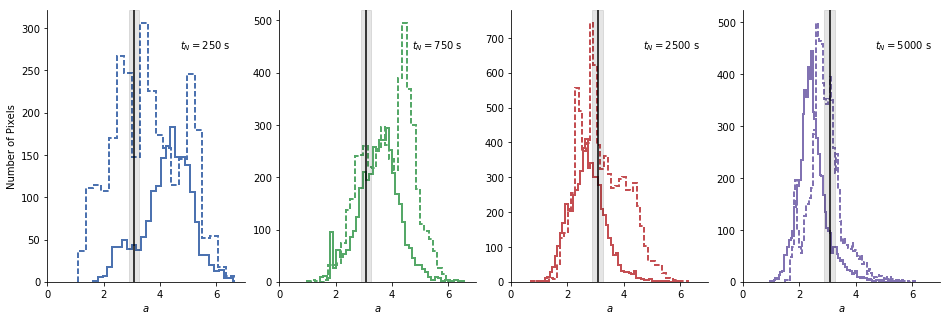

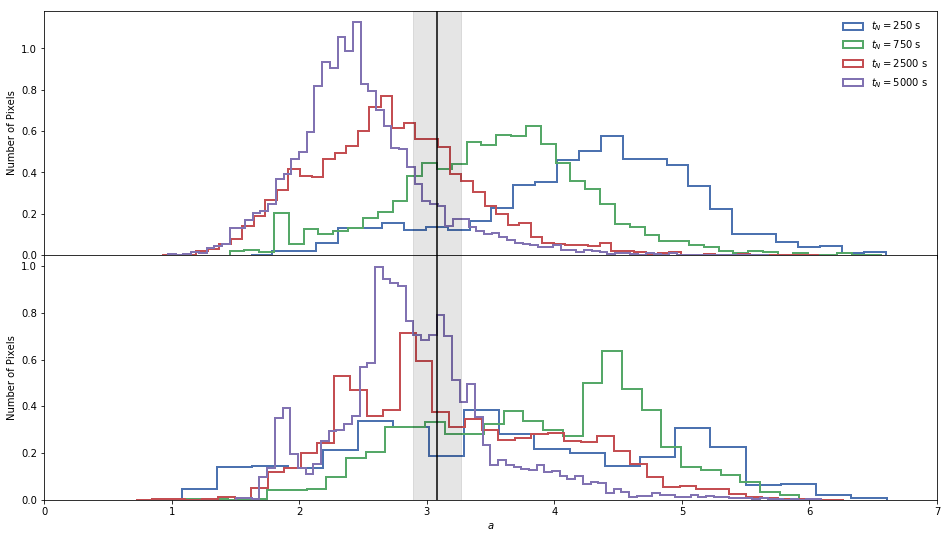

In [145]:
fig,axes = plt.subplots(1,4,figsize=(16,5),sharex=True,sharey=False)
plt.subplots_adjust(wspace=0.175)
fig2,axes2 = plt.subplots(2,1,figsize=(16,9),sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.)
colors = sns.color_palette('deep')
for ax,(i,freq) in zip(axes.flatten(),enumerate(frequencies)):
    #### Ground Truth ####
    tmp = (EMCube.restore('../data/em_cubes_true_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,4e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .data.flatten()
          )
    tmp = tmp[tmp>0]
    _,bins = np.histogram(tmp,bins='fd')
    ax.hist(tmp,bins=bins,
            histtype='step',log=False,label='$t_N={}$ s, truth'.format(freq),normed=False,cumulative=False,
            lw=2,alpha=1.,color=colors[i])
    axes2[0].hist(tmp,bins=bins,
            histtype='step',log=False,label='$t_N={}$ s'.format(freq),normed=True,cumulative=False,
            lw=2,alpha=1.,color=colors[i])
    #### Regularized Inversion ####
    tmp = (EMCube.restore('../data/em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,3e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .data.flatten()
          )
    tmp = tmp[tmp>0]
    _,bins = np.histogram(tmp,bins='fd')
    hist,_,_ = ax.hist(tmp,bins=bins,
                       histtype='step',log=False,label='$t_N={}$ s, demreg'.format(freq),normed=False,
                       lw=2,ls='--',alpha=1.,cumulative=False,color=colors[i])
    axes2[1].hist(tmp,bins=bins,
            histtype='step',log=False,normed=True,
            lw=2,ls='-',alpha=1.,cumulative=False,color=colors[i])
    #### Warren et al result ####
    # from paper
    warren_a_ar9_nominal_hk12 = 3.08
    warren_a_ar9_minus_hk12 = warren_a_ar9_nominal_hk12 - 0.19
    warren_a_ar9_plus_hk12 = warren_a_ar9_nominal_hk12 + 0.19
    #ax.axvspan(warren_a_ar9_nominal - warren_a_ar9_uncertainty,
    #           warren_a_ar9_nominal + warren_a_ar9_uncertainty,
    #          color='k',alpha=0.1)
    #ax.axvline(x=warren_a_ar9_nominal,color='k')
    # from HK12 applied to reported intensities
    ax.axvspan(warren_a_ar9_minus_hk12,
               warren_a_ar9_plus_hk12,
              color='k',alpha=0.1)
    ax.axvline(x=warren_a_ar9_nominal_hk12,color='k')
    ax.set_xlim([0,7])
    #ax.legend(loc=2)
    ax.set_xlabel(r'$a$')
    ax.text(4.7,0.9*np.max(hist),r'$t_N={}$ s'.format(freq),
            fontsize=matplotlib.rcParams['axes.labelsize'])

axes2[0].axvspan(warren_a_ar9_minus_hk12,
               warren_a_ar9_plus_hk12,
              color='k',alpha=0.1)
axes2[0].axvline(x=warren_a_ar9_nominal_hk12,color='k')
axes2[1].axvspan(warren_a_ar9_minus_hk12,
               warren_a_ar9_plus_hk12,
              color='k',alpha=0.1)
axes2[1].axvline(x=warren_a_ar9_nominal_hk12,color='k')
axes[0].set_ylabel(r'Number of Pixels')
axes2[0].set_xlim([0,7])
axes2[0].legend(loc='best',frameon=False)
axes2[1].set_xlabel(r'$a$')
axes2[0].set_ylabel(r'Number of Pixels')
axes2[1].set_ylabel(r'Number of Pixels')
sns.despine(fig=fig)

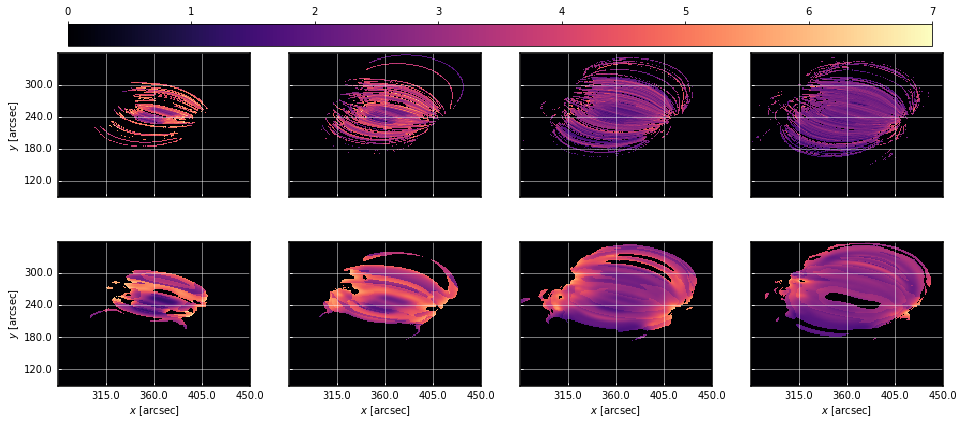

In [147]:
fig = plt.figure(figsize=(20,6.2))
plt.subplots_adjust(top=0.9)
cax = fig.add_axes([0.132, 0.9,0.6, 0.05])
for i,freq in enumerate(frequencies):
    #### Ground Truth ####
    tmp = (EMCube.restore('../data/em_cubes_true_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,4e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((90,360),u.arcsec))
          )
    ax = fig.add_subplot(2,5,i+1,projection=tmp)
    custom_cmap = plt.get_cmap('magma')
    im = (tmp.plot(vmin=0,vmax=7,cmap=custom_cmap,axes=ax,title=False,annotate=False,norm=None))
    if i==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    #### Regularized Inversion ####
    tmp = (EMCube.restore('../data/em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,3e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((90,360),u.arcsec))
          )
    ax = fig.add_subplot(2,5,i+6,projection=tmp)
    custom_cmap = plt.get_cmap('magma')
    im = (tmp.plot(vmin=0,vmax=7,cmap=custom_cmap,axes=ax,title=False,annotate=False,norm=None))
    ax.set_xlabel(r'$x$ [{}]'.format(u.Unit(tmp.meta['cunit1'])))
    if i==0:
        ax.set_ylabel(r'$y$ [{}]'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
cbar = fig.colorbar(im,cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')